# AI 574 Final Project
## 0.1 Article Summarization fine tuned for articles about deep learning

**Team:** Joseph Reid, Praneeth Sunkavalli, Yashvi Dilipbhai Pipaliya

**Course:** AI 574 - Natural Language Processing (Summer, 2024)  

### 0.1.1 Problem Statement

+ This project is focused on the performance of finetuned "small" large language models (LLMs).  Specifically, when using a corpus of text which is composed of academic articles within the domain of deep learning methods, what kind of performance can be achieved with various LLMs when creating text summarizations based on fine tuned models.  Our results will provide a comparison of multiple, open-source LLM's which are fine tuned off of a dataset and the text summarizations are compared against gold standard summarizations that have been produced.

+ **Keywords:** Finetune, Summarization, Technical Documents, LLM

### 0.1.2 Data Collection

+ Source(url): https://cs.stanford.edu/~myasu/projects/scisumm_net/

+  Short Description:  "We provide the 1000 most cited papers in the ACL Anthology Network (AAN) (Radev et al., 2013) with their annotated citation information and gold summaries."  The provided summaries are human annotated.

+  Keywords:  ACL Anthology Network, summaries, papers

### 0.1.3 Required Packages

+  A number of required packages are used for this process.  Many are standard (such as numpy, pandas, os, and others); however, for the other packages, a pip install should be applied in order to resolve the environment.  

+  Major packages include torch, nltk, transformers, rouge, wordcloud, datasets, and bert_score.

+  For any major packages that are not yet installed, please uncomment the proper pip install.

In [3]:
#!pip install rouge
#!pip install nltk
#!pip install wordcloud
#!pip install datasets
#!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
#!pip install bert_score
#!pip install transformers
#!pip install evaluate
#!pip install rouge_score


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



  Obtaining dependency information for rouge from https://files.pythonhosted.org/packages/32/7c/650ae86f92460e9e8ef969cc5008b24798dcf56a9a8947d04c78f550b3f5/rouge-1.0.1-py3-none-any.whl.metadata


In [4]:
# Libraries to read and parse data
import os
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

# Libraries to clean and visualize data
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import nltk
#nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


# Libraries to score output
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from rouge import Rouge
import rouge_score

from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

import transformers
from transformers import AutoTokenizer, DataCollatorForSeq2Seq 
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

import evaluate
import datasets

import torch
import wandb
wandb.init(mode='disabled')


from diagrams import Cluster, Diagram, Edge

from diagrams.aws.compute import EC2
from diagrams.aws.database import RDS
from diagrams.aws.ml import Sagemaker, Textract
from diagrams.generic.storage import Storage
from diagrams.aws.storage import S3
from diagrams.aws.compute import EC2Instances, Lambda, EC2Instance
from diagrams.aws.analytics import Glue, GlueCrawlers, EMREngine
from diagrams.aws.cost import CostExplorer, CostAndUsageReport
from diagrams.ibm.devops import Provision

OSError: [WinError 126] The specified module could not be found. Error loading "C:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\lib\fbgemm.dll" or one of its dependencies.

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

#Finally, just to make sure that the GPU is currenlty fully available before we start.
print(torch.cuda.memory_allocated())
#print(torch.cuda.memory_summary())

### 0.1.4 Data Preprocessing

+  Create Functions to read the files
    -  Create a list of the sub-directories containing xml files
    -  Create code to fully read and parse the xml file
    -  Loop through all XML files, reading them
    -  Find the corresponding text file while in the loop and strip the title and the summary from each.
    -  Store the results in a list of dictionary elements

+  Create and validate the list of file locations
+  Loop and read all of the files
+  Explore the data
    -  If either the summary or text is missing, add to a list and then remove all of these entries
    -  Explore the lengths of the articles and the summaries
    -  Produce baseline summaries from the text to obtain key-words and represent them in a word cloud.
    -  Randomly split data into training, validation, and test set
    -  Store data into the correct format for training

#### Functions for reading data

In [5]:
# First, we need a function that walks through the full directory and finds all of the xml files.
#  This function isn't too hard.  Provided with a root directory, it creates a blank list and then 
#  walks down the subdirectories.  Every time it finds an xml file, it adds it to the list.
def list_xml_files(directory):
    xml_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.xml'):
                xml_files.append(os.path.join(root, file))
    return xml_files

In [6]:
# Now, we start defining functions to parse the XML file itsself.  For every header at level one that we find 
#  within the XML file, we need to pull it's title.  The ABSTRACT seems to pull out correctly, but for any further
#  major sections in the paper, the attribute of "title" ends up holding the title of the section.  As such, we use
#  the element tag to hold the section title if it doesn't have a specific title.  If it does, then the title is held.
#  This function creates a list of the data for the entire paper.  Specifically, if the depth of the XML tree is at 1, it
#  iterates through the children of this tree and pulls out all of the text from the file.  This is then appended to a list
#  to store all of the data.

def parse_element(element, depth = 0):
    data = []
    
    if depth == 1 :
        if element.tag == 'SECTION':
            header = element.attrib.get('title')
        else:
            header = element.tag
        content = []
        
        for child in element:
            content.append(child.text.strip() if child.text else '')
        
        if content:
            data.append((header, '\n'.join(content)))
    
    for child in element:
        data.extend(parse_element(child, depth + 1))
    
    return data

In [7]:
# In order to use the prse_element function, we need to retrieve the file from the tree
# and then apply the parsing function to the root retrieved from the path to that paper

def parse_xml_file(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    return parse_element(root, depth = 0)

#  For each of these we also need to read a text file
def read_text_file(file_path):
    with open(file_path, 'r', encoding = 'utf-8') as file:
        return file.read().strip()

In [8]:
# Finally, we need to join all of the section headers and text into a single text item.
#  This item will fill our dictionary text item for the articles that we are training from.

def format_to_text(data):
    formatted_text = []
    
    for header, content in data:
        formatted_text.append(header)
        formatted_text.append(content)
    return '\n\n'.join(formatted_text)

In [9]:
def read_files(xml_file_path):
    base_path = os.path.dirname(xml_file_path)
    xml_file_name = os.path.basename(xml_file_path).replace('.xml', '')
    summary_file_path = os.path.join(base_path, '..', 'summary', f'{xml_file_name}.gold.txt')
    
    xml_data = parse_xml_file(xml_file)
    document_text = format_to_text(xml_data)
    
    summary_text = read_text_file(summary_file_path)
    
    lines = summary_text.split('\n', 1)
    title = lines[0].strip() if lines else ''
    summary = lines[1].strip() if len(lines) > 1 else ''
    
    results = {
        'text': document_text,
        'summary': summary,
        'title': title
    }
    
    return results

#### Reading the documents:
There are 1009 documents in our sample dataset, so we need to generate a list of the files that store those documents.  
This code will generate a list of the links to the xml files.  These file names are then used to track down the summaries as well with the functions presented above.  In the end, we end up with a list of dictionary items containing the text, summary, and title for each article.

In [10]:
directory = "top1000_complete"  # Root directory for all of the files.
xml_files = list_xml_files(directory)

In [11]:
print(len(xml_files))  # Making sure that all 1009 files were detected

1009


In [12]:
xml_files[1]  # Just double checking the file paths that are generated with an example

'top1000_complete\\A00-1043\\Documents_xml\\A00-1043.xml'

**Reading all the documents:**  Here we loop through all of the documents and append every document/title/summary to a list of dictionaries called "data"

In [13]:
data = []
for xml_file in xml_files:
    file = read_files(xml_file)
    data.append(file)

In [16]:
data[:2]  # Again, just to make sure that the data was read correctly, we can look at an example.

[{'text': "ABSTRACT\n\nTrigrams'n'Tags (TnT) is an efficient statistical part-of-speech tagger.\nContrary to claims found elsewhere in the literature, we argue that a tagger based on Markov models performs at least as well as other current approaches, including the Maximum Entropy framework.\nA recent comparison has even shown that TnT performs significantly better for the tested corpora.\nWe describe the basic model of TnT, the techniques used for smoothing and for handling unknown words.\nFurthermore, we present evaluations on two corpora.\n\n1 Introduction\n\nA large number of current language processing systems use a part-of-speech tagger for pre-processing.\nThe tagger assigns a (unique or ambiguous) part-ofspeech tag to each token in the input and passes its output to the next processing level, usually a parser.\nFurthermore, there is a large interest in part-ofspeech tagging for corpus annotation projects, who create valuable linguistic resources by a combination of automatic pr

Our data is now in a list of dictionaries which matches the billsum dataset within the tutorial provided by huggingface at https://huggingface.co/docs/transformers/v4.17.0/en/tasks/summarization

Based on this, we should be able to fine tune our model.  Next up, we will clean and explore the dataset.  One additional quick step that we should take will be to convert our dataset into the right format and then apply a splitting to the data in order to test the results.

#### Explore the dataset

In [17]:
# First we need to make a list of any articles that do not have any text or do not have a summary.

indices_to_delete = []
for i in range(len(data)):
    if(len(data[i]['summary'])==0 or len(data[i]['text'])==0):
        indices_to_delete.append(i)

In [18]:
print(indices_to_delete)

[25, 26, 27, 28, 29, 30, 34, 38, 42, 46, 49, 65, 67, 68, 69, 70, 72, 73, 75, 76, 78, 79, 81, 82, 83, 84, 85, 86, 87, 89, 92, 94, 95, 96, 98, 107, 196, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 224, 259, 262, 270, 304, 309, 314, 343, 344, 368, 698, 709, 713, 808, 850, 870, 947, 991]


In [20]:
 # If we look at this list a little more in detail, 
    #we can see that some of these articles are indeed missing the text or summary
data[25] 

{'text': '',
 'summary': 'Previous stochastic approaches to generation do not include a tree-based representation of syntax.\nWhile this may be adequate or even advantageous for some applications, other applications profit from using as much syntactic knowledge as is available, leaving to a stochastic model only those issues that are not determined by the grammar.\nWe present initial results showing that a tree-based model derived from a tree-annotated corpus improves on a tree model derived from an unannotated corpus, and that a tree-based stochastic model with a hand-crafted grammar outperforms both.\nOur system, FERGUS takes dependency structures as inputs, and produced XTAG derivations by a stochastic tree model automatically acquired from an annotated corpus.\nThe Fergus system employs a statistical tree model to select probable trees and a word n-gram model to rank the string candidates generated from the best trees.',
 'title': 'Exploiting A Probabilistic Hierarchical Model For 

In [21]:
# In this case, we should remove these articles from our list
def delete_indices(original_list, indices_to_delete):
    return [elem for idx, elem in enumerate(original_list) if idx not in indices_to_delete]


print('The dataset before deleting:', len(data))
data = delete_indices(data, indices_to_delete)
print('The dataset after deleting:', len(data))

The dataset before deleting: 1009
The dataset after deleting: 943


In [23]:
# Check dataset size and shape
print("Dataset size and shape:")
print(len(data))

# Display structure of the first paper
print("\nSample of the dataset:")
print(data[0])

# Check keys available in the first paper
print("\nKeys available in the first paper:")
print(data[0].keys())

Dataset size and shape:
943

Sample of the dataset:
{'text': "ABSTRACT\n\nTrigrams'n'Tags (TnT) is an efficient statistical part-of-speech tagger.\nContrary to claims found elsewhere in the literature, we argue that a tagger based on Markov models performs at least as well as other current approaches, including the Maximum Entropy framework.\nA recent comparison has even shown that TnT performs significantly better for the tested corpora.\nWe describe the basic model of TnT, the techniques used for smoothing and for handling unknown words.\nFurthermore, we present evaluations on two corpora.\n\n1 Introduction\n\nA large number of current language processing systems use a part-of-speech tagger for pre-processing.\nThe tagger assigns a (unique or ambiguous) part-ofspeech tag to each token in the input and passes its output to the next processing level, usually a parser.\nFurthermore, there is a large interest in part-ofspeech tagging for corpus annotation projects, who create valuable li

In [22]:
# And, we can access the dictionary elements of the remaining articles by their name:  "text", "summary", "title" as follows
data[0]['summary']

"Trigrams'n'Tags (TnT) is an efficient statistical part-of-speech tagger.\nContrary to claims found elsewhere in the literature, we argue that a tagger based on Markov models performs at least as well as other current approaches, including the Maximum Entropy framework.\nA recent comparison has even shown that TnT performs significantly better for the tested corpora.\nWe describe the basic model of TnT, the techniques used for smoothing and for handling unknown words.\nFurthermore, we present evaluations on two corpora.\nWe achieve the automated tagging of a syntactic-structure-based set of grammatical function tags including phrase-chunk and syntactic-role modifiers trained in supervised mode from a tree bank of German."

#### Visualize and explore the data

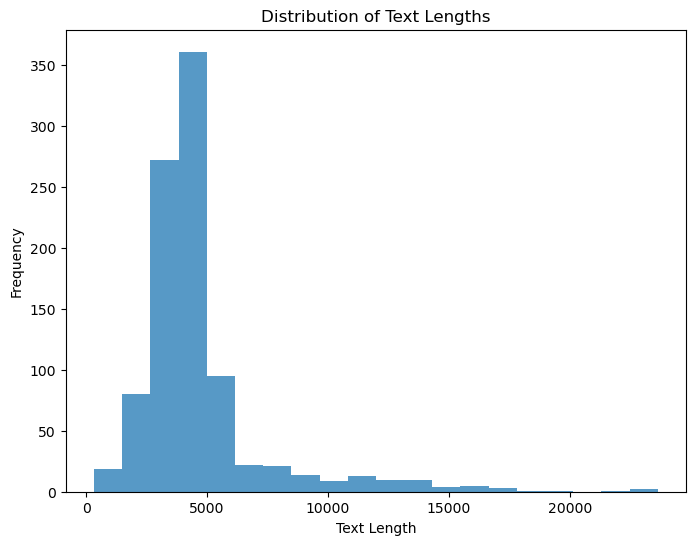

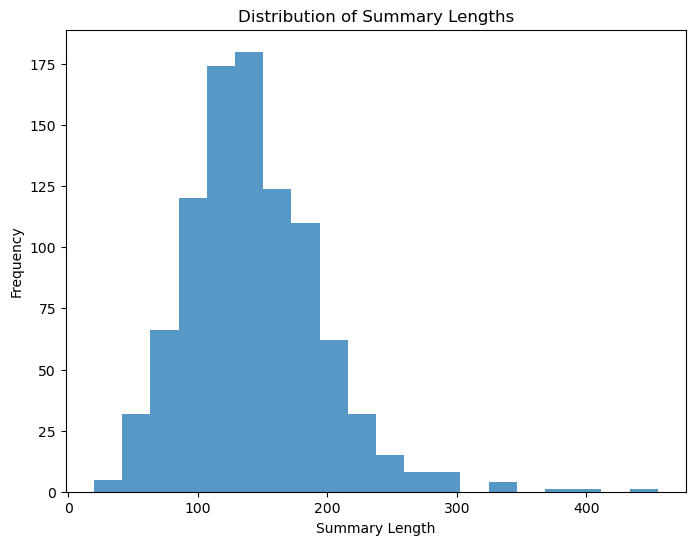

In [25]:
# Calculate text lengths
text_lengths = [len(paper['text'].split()) for paper in data]

# Calculate summary lengths
summary_lengths = [len(paper['summary'].split()) for paper in data]

# Plot histogram of text lengths
plt.figure(figsize=(8, 6))
plt.hist(text_lengths, bins=20, alpha=0.75)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.show()

# Plot histogram of summary lengths
plt.figure(figsize=(8, 6))
plt.hist(summary_lengths, bins=20, alpha=0.75)
plt.xlabel('Summary Length')
plt.ylabel('Frequency')
plt.title('Distribution of Summary Lengths')
plt.show()


From above, we can see that the vast majority of papers have below about 5000 to 6000 tokens and the majority of the summaries are below 200 tokens.  This is useful information for training the model in terms of knowing what an ideal input and output length will be for our models.  We can continue to explore this data by looking at the topics and the words associated with those topics.

In [29]:
stop_words = set(stopwords.words('english'))

# Vectorize the text data
texts = [paper['text'] for paper in data]
vectorizer = CountVectorizer(max_features=3000, stop_words='english')
X = vectorizer.fit_transform(texts)

# Apply LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Display topics and top words for each topic
def display_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

print("\nTop 5 topics and their top words:")
display_topics(lda, vectorizer.get_feature_names_out(), 5)



Top 5 topics and their top words:

Topic 1:
quot semantic example verb noun

Topic 2:
text data task results used

Topic 3:
word data words training features

Topic 4:
model tree parsing parser dependency

Topic 5:
word translation model words english


#### Create wordcloud of keywords associated with topics.

In order to create this visualization, we start by creating "summaries" and scoring the summaries as they stand.

In [28]:
def generate_summary(text):
    return ' '.join(text.split())

# Initialize Rouge object
rouge = Rouge()
rouge_scores = []

# Calculate BLEU score for each paper
bleu_scores = []
for paper in data:
    reference_summary = paper['summary']
    full_text = paper['text']
    
    # Generate candidate summary (replace with your actual model's summary generation)
    candidate_summary = generate_summary(full_text)
    
    # Compute Sentence BLEU score
    bleu_score = sentence_bleu([reference_summary.split()], candidate_summary.split())
    bleu_scores.append(bleu_score)
    
    # Compute ROUGE scores
    scores = rouge.get_scores(candidate_summary, reference_summary)
    rouge_scores.append(scores)

# Print individual BLEU scores and their average
#print("Individual BLEU scores:", bleu_scores)
print("Average BLEU score:", np.mean(bleu_scores))

avg_rouge_scores = {
    'rouge-1': {'f': 0.0, 'p': 0.0, 'r': 0.0},
    'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0},
    'rouge-l': {'f': 0.0, 'p': 0.0, 'r': 0.0}
}

for scores in rouge_scores:
    for metric in avg_rouge_scores.keys():
        avg_rouge_scores[metric]['f'] += scores[0][metric]['f']
        avg_rouge_scores[metric]['p'] += scores[0][metric]['p']
        avg_rouge_scores[metric]['r'] += scores[0][metric]['r']

num_papers = len(rouge_scores)
for metric in avg_rouge_scores.keys():
    avg_rouge_scores[metric]['f'] /= num_papers
    avg_rouge_scores[metric]['p'] /= num_papers
    avg_rouge_scores[metric]['r'] /= num_papers

print("\nAverage ROUGE scores across all papers:")
print(avg_rouge_scores)


Average BLEU score: 0.026402568652877368

Average ROUGE scores across all papers:
{'rouge-1': {'f': 0.13328045926759371, 'p': 0.0729169886242015, 'r': 0.9029648707833469}, 'rouge-2': {'f': 0.06438240595121249, 'p': 0.03412859738307871, 'r': 0.7528091419155732}, 'rouge-l': {'f': 0.13155727744006304, 'p': 0.07197151245043376, 'r': 0.8917111197631462}}


BLEU is a measure of the n-grams in the summary texts that appear in the original texts.  The score is between 0 and 1 and higher scores tend to indicate a better summary.  In this case, a score of 0.026 indicates poor quality in terms of a generated summary.

Rouge-1 is based on the unigram overlap of the summary when compared with the original text.
Rouge-2 applies bigram comparisons the same way that Rouge-1 does.  
Rouge-L measures the longest subsequence that the summary has in common with the reference text.  Here again, it's based on a ratio calculation.  

Within the rouge measures, R (Recall) is the proportion of reference n-grams in the summary which indicates coverage of the original content.  P (Precision) is calculated as the proportion of n-grams in the summary when compared with the reference text and indicates the relavence of the generated content.  Finally, "f" is a weighted comparison of precision and recall.  In general, these results show high recall (i.e. appropriate coverage) but low percision (indicating poor relevance) for the baseline generated summaries.

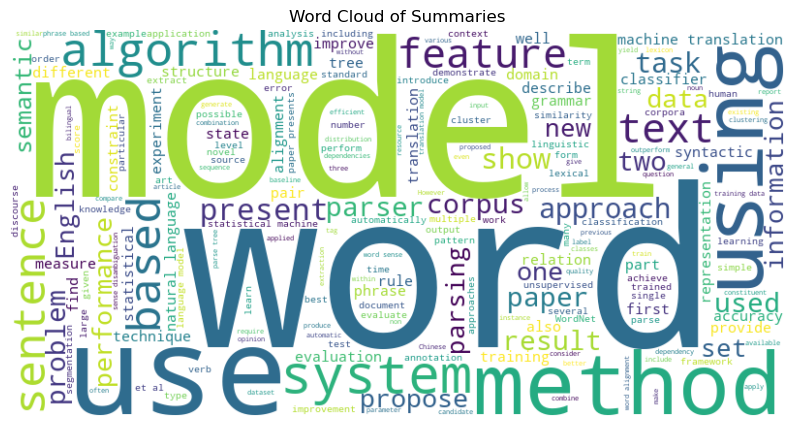

In [31]:
# Word cloud of most frequent words in summaries
all_summaries = ' '.join([paper['summary'] for paper in data])
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=set(stop_words)).generate(all_summaries)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Summaries')
plt.show()

#### Store the list of dictonaries into the DatasetDict format required for fine tuning a huggingface mdoel

In [34]:
dataset = Dataset.from_dict({
    'text': [item['text'] for item in data],
    'summary': [item['summary'] for item in data],
    'title': [item['title'] for item in data]
})

So, provided that we now have a list of the dictionary elements stored as a dataset, we need to split this dataset into a training set, a validation set, and a hold-out test set.  The training and validation sets will be used to train and evaluate the models during the training process.  The test set will be used to compare in order to check for overtraining and evaluate the final product for each model.  This splitting is reproducible using the seed.

In [35]:
train_data_temp, test_data = dataset.train_test_split(test_size = 0.15, seed = 42).values()
train_data, valid_data = train_data_temp.train_test_split(test_size = 0.176, seed = 42).values()

In [36]:
data_dict = DatasetDict({
    'train': train_data,
    'valid': valid_data,
    'test': test_data
})

In [37]:
print(len(data_dict['train']))  #Number of training samples
print(len(data_dict['valid']))  # Number of validation samples
print(len(data_dict['test']))  #  Number of testing samples

660
141
142


So, we have 660 training samples, 141 samples for validation, and 142 in the testing samples.

In [39]:
type(data_dict)  #Check the object type

datasets.dataset_dict.DatasetDict

In [47]:
print(data_dict['train'][0]['text'])  #Make sure that the article is comming accross properly.

ABSTRACT

Automatic sentiment classification has been extensively studied and applied in recent years.
However, sentiment is expressed differently in different domains, and annotating corpora for every possible domain of interest is impractical.
We investigate domain adaptation for sentiment classifiers, focusing on online reviews for different types of products.
First, we extend to sentiment classification the recently-proposed structural correspondence learning (SCL) algorithm, reducing the relative error due to adaptation between domains by an average of 30% over the original SCL algorithm and 46% over a supervised baseline.
Second, we identify a measure of domain similarity that correlates well with the potential for adaptation of a classifier from one domain to another.
This measure could for instance be used to select a small set of domains to annotate whose trained classifiers would transfer well to many other domains.

1 Introduction

Sentiment detection and classification has 

## 0.1.5 Methodology

The process for fine tuning is slightly complex, so we start by creating a diagram to explain our full process.  This next code cell simply contains the code to produce this diagram.

In [51]:
with Diagram("Fine Tuning", show=False, direction = "LR") as diag2:
             
    with Cluster("Data Collection"):
        source_data = [Storage("Source Data") 
                        >> S3("XML and Text Files")]
    
    with Cluster("Data Retrieval"):
        List_XML = GlueCrawlers("Find all XML Files") 
        with Cluster("Retrieve Dictionary Entry"):
            Data_Entry = [EC2Instances("Parse XML"), EC2Instances("Title"), EC2Instances("Summary")] 
        Format_dict = Glue("Format Dictionary")
        
    
    with Cluster("Data Preprocessing"):
        data_splitting = Provision("Data Splitting")  
        with Cluster("Data Split"):
            Data = [EC2Instances("Training Data"), EC2Instances("Validation Data"), EC2Instances("Testing Data")]
        tokenization = Lambda("Tokenization")
    
    
    with Cluster(label = "Tokenized Data", graph_attr={"style": "filled", "fillcolor": "lightgreen"}):
        Tokenized_Training_Data = EC2("Tokenized Training Data")
        Tokenized_Validation_Data = EC2("Tokenized Validation Data")
        Tokenized_Testing_Data = EC2("Tokenized Testing Data")
    
    List_XML >> Data_Entry >> Format_dict
    source_data >> List_XML 
    Format_dict >> data_splitting
    data_splitting >> Data >> tokenization
    tokenization >> Tokenized_Training_Data 
    
    
    with Cluster(label="Model", direction="LR", graph_attr={"style": "filled", "fillcolor": "lightgreen"}):
        Tokenizer = Sagemaker("Tokenizer")
        Model = EMREngine("Model")
    
    Tokenizer >> tokenization
    
    with Cluster(label = "Parameters", graph_attr={"style": "filled", "fillcolor": "lightgreen"}):
        Metric = CostExplorer("ROUGE metric")
        Hyperparameters = CostAndUsageReport("Hyperparameters")
    

    Fine_Tune = Lambda("Fine Tuning")
    
    Metric >> Fine_Tune
    Model >> Fine_Tune
    Hyperparameters >> Fine_Tune
    Tokenized_Training_Data >> Fine_Tune
    Tokenized_Validation_Data >> Fine_Tune
    
    with Cluster(label = "Tuned Model"):
        Trained_Tokenizer = Sagemaker("Tuned Tokenizer")
        Tuned_Model = EMREngine("Tuned Model")
        
    
    Fine_Tune >> Trained_Tokenizer
    Fine_Tune >> Tuned_Model
    
    with Cluster(label = "Testing", graph_attr={"style": "filled", "fillcolor": "lightgray"}):
        Generate_Summaries = Lambda("Generate Summaries")
        Evaluate_Testing = Textract("Evalutate Testing Data")
        
    Tokenized_Testing_Data >> Generate_Summaries
    Tuned_Model >> Generate_Summaries
    
    Metric >> Evaluate_Testing
    Generate_Summaries >> Evaluate_Testing
    
    
    New_Data = EC2("New Data")
    
    with Cluster(label = "Deploy", graph_attr={"style": "filled", "fillcolor": "lightpink"}):
        Tokenize_new = Lambda("Tokenizer")
        Token_new_data = EC2("Tokenized New Data")
        Generate_Summary = Lambda("Generate Summary")
        Decode = Textract("Decode Summary")
        
    New_Data >> Tokenize_new
    Trained_Tokenizer >> Tokenize_new
    Tokenize_new >> Token_new_data
    Token_new_data >> Generate_Summary
    Tuned_Model >> Generate_Summary
    Generate_Summary >> Decode

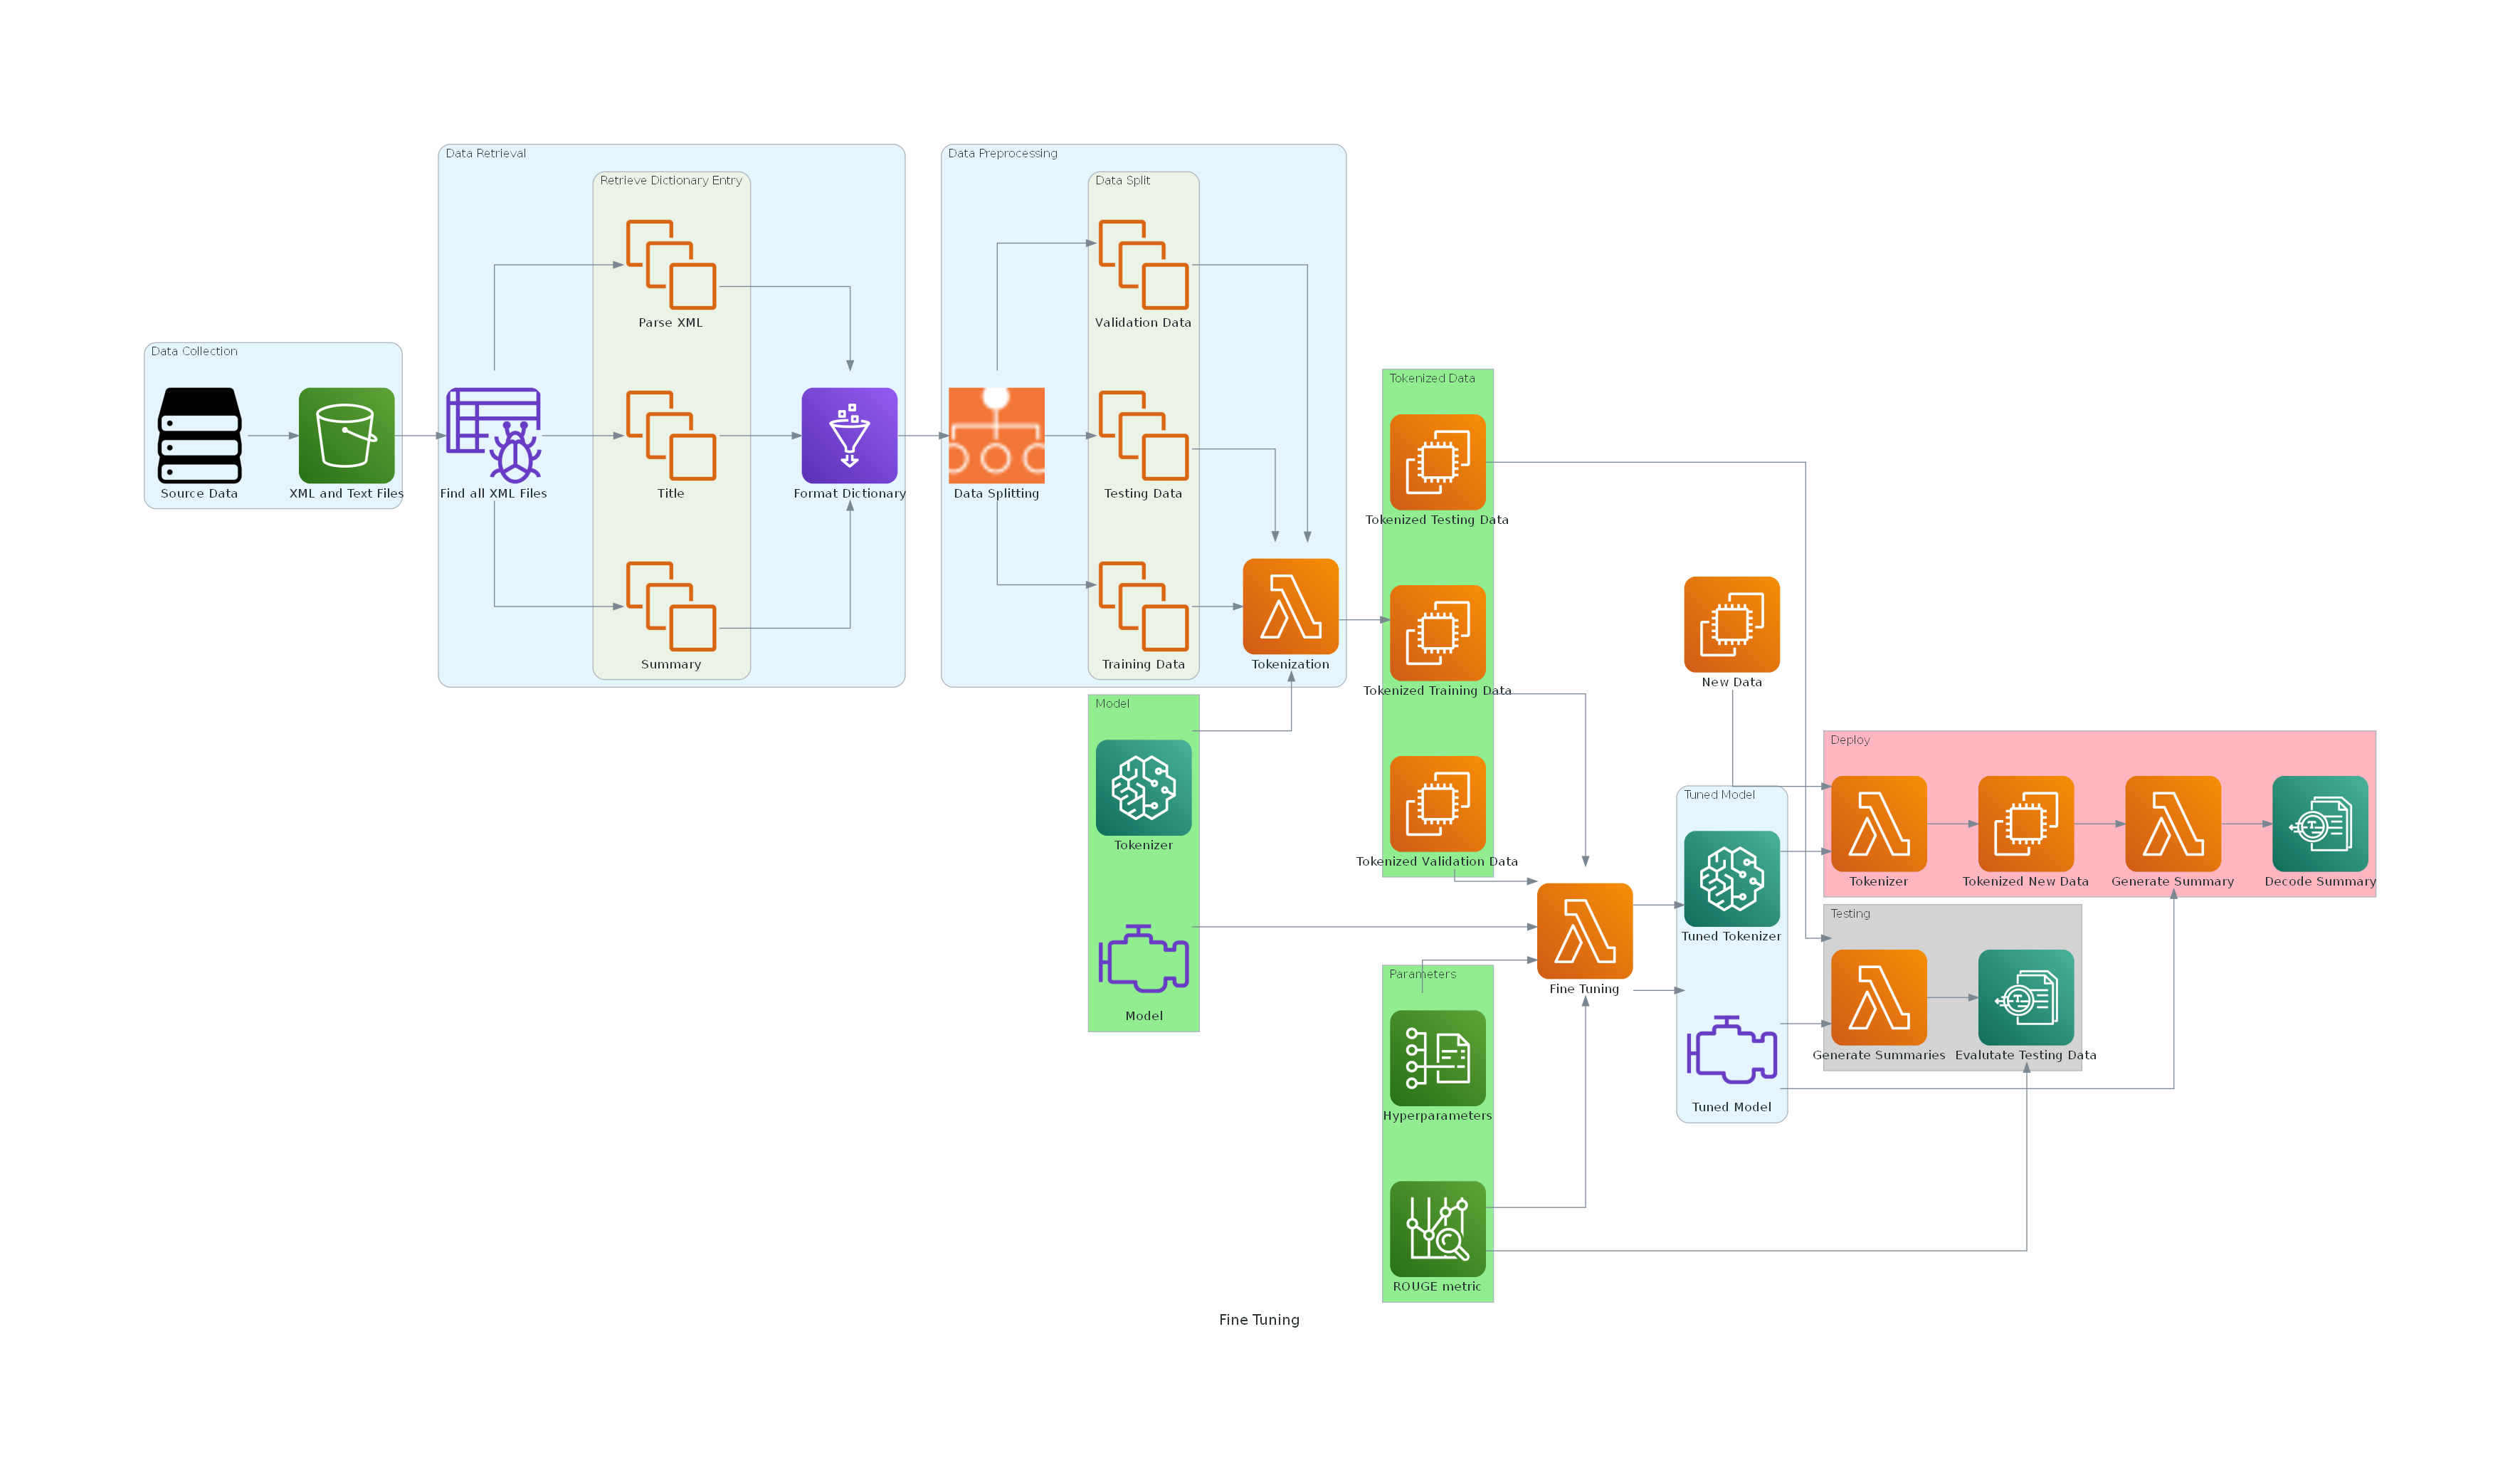

In [52]:
diag2

#### Deep Learning Process:  Fine Tuning

Fine tuning is the process by which pre-defined models are partially retrained by using a unique dataset. In this way, the model has an updated set of weights and biases which will provide better results when compared to the base model when performing NLP tasks.  In our process, 


#### Models

The initial proposal for this study was to employ the nv-embed model that has recently been generated by NVIDIA.  Upon further exploration, this model is propriatory and requires that we sign an agreement to use it.  Furthermore, it is slightly too large to run.  We aslo explored using Mistral and Meta-Llama using cloud services.  Both of these models were too large to train on local or cloud services without crashing.  As such, we began to explore a set of much smaller models.  These models include the T5-small, BART-large-cnn, pegasus-xsum, and pegasus-samsum models.  These models are present on huggingface and are described below.

##### T5-Small


##### BART-large-cnn


##### pegasus-xsum


##### pegasus-samsum


**Keywords**:  Fine-Tuning, LLM, summarization, T5-small, bart-large-cnn, pegasus-xsum, pegasus-samsum

## 0.1.7 Model Fitting and Validation

The following code cells contain the code which defines our model fitting and evaluation process.  In order to compare results, all models are prepaired and trained on the same set of hyperparameters which are described within the training arguments.  The training process is wrapped within a function which first preprocesses the data and defines a function to compute the metrics (ROUGE) which we will use to train and interpret the results of this process.  Finally, the best model checkpoint is saved and then reloaded in order to apply the fine-tuned model to the test set.  The results of this test set evaluation are presented after training each model.  Finally, the results will be collated into a table within our final paper in order to compare the results of each model.  

In [ ]:
os.environ['TRANSFORMERS_NO_ADVISORY_WARNINGS'] = 'true'

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# torch.cuda.get_device_name(0)

In [ ]:
def train_model(nmodel,token,epochs):
    model_name = nmodel
    checkpoint = model_name
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    
    prefix = "summarize: "

    def preprocess_function(examples,token):
        inputs = [prefix + doc for doc in examples["text"]]
        model_inputs = tokenizer(inputs, max_length = token, truncation = True)
        labels = tokenizer(text_target = examples["summary"], max_length = 256, truncation = True)
        model_inputs["labels"] = labels["input_ids"]
        return model_inputs
    
    tokenized_data = data_dict.map(lambda examples: preprocess_function(examples, token), batched=True)
    data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer, model=checkpoint, return_tensors = 'pt')
    rouge = evaluate.load("rouge")
    bertscore = evaluate.load("bertscore")
    
    def compute_metrics(eval_pred):
        predictions, labels = eval_pred
        decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens = True)
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens = True)
        result = rouge.compute(predictions = decoded_preds, references = decoded_labels, use_stemmer = True)
        prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
        result["gen_len"] = np.mean(prediction_lens)
        return {k: round(v, 4) for k, v, in result.items()}
    
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
    model.generation_config.max_new_tokens = token
    
    print(model)
    
    training_args = Seq2SeqTrainingArguments(
        num_train_epochs = epochs,
        per_device_train_batch_size = 16,
        per_device_eval_batch_size = 16,
        output_dir = "results/"+model_name,
        learning_rate = 2e-4,
        weight_decay = 0.01,
        save_total_limit = 1,
        predict_with_generate = True,
        fp16 = False,
        push_to_hub = False,
        
        # Early stopping parameters
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        #greater_is_better=False,
        logging_dir='./logs',
        logging_steps=3,
        evaluation_strategy="steps",
        save_steps=3,
    )

    trainer = Seq2SeqTrainer(
        model = model,
        args = training_args,
        train_dataset = tokenized_data["train"],
        eval_dataset = tokenized_data["valid"],
        tokenizer = tokenizer,
        data_collator = data_collator,
        compute_metrics = compute_metrics,
    )
    
    print(trainer.train())
    
    save_directory = "results/"+model_name
    tokenizer.save_pretrained(save_directory)
    trainer.save_model(save_directory)
    
    tokenizer = AutoTokenizer.from_pretrained("results/"+model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained("results/"+model_name)
    
    def generate_summaries(inputs):
        inputs = tokenizer(inputs, return_tensors='pt', padding = True, truncation = True)
        with torch.no_grad():
            outputs = model.generate(inputs['input_ids'], max_new_tokens = 256, min_new_tokens = 100, num_beams = 4, 
                                     early_stopping = True)
        return tokenizer.batch_decode(outputs, skip_special_tokens = True)
    
    generated_texts = []
    for example in tokenized_data['test']:
        input_text = example['text']
        prediction = generate_summaries(input_text)
        generated_texts.append(prediction[0])
        
    true_summaries = [example['summary'] for example in data_dict['test']]
    result1 = rouge.compute(predictions = generated_texts, references = true_summaries, use_stemmer = True)
    result2 = bertscore.compute(predictions = generated_texts, references = true_summaries, use_stemmer = True)
    
    print("Rogue Results on Holdout Set:")
    print(result1)
    
    print("BERTScore Results on Holdout Set:")
    print(result2)
    
    print("Example of Generated Text on Holdout Set:")
    print(generated_texts[1])
    
    print("Example of Original Text on Holdout Set:")
    print(true_summaries[1])
    
    
    return model

## 0.1.7 Model Evaluation

As we are employing a number of different models, each must be trained on a different run of the notebook due to limitations on GPU memmory.  The evaluation of these models on the test-set (hold out) is presented within the output of the model training and described below each model.

In [ ]:
#model1 = train_model("Feluda/pegasus-samsum",1024,5)

In [ ]:
#model2 = train_model("google-t5/t5-small",1024,5)

In [ ]:
#model3 = train_model("facebook/bart-large-cnn",1024,5)

In [ ]:
#model4 = train_model("Feluda/pegasus-xsum",1024,5)

## 0.1.8 Issues and Improvements

+  Dataset could be larger.  Approx 1000 cases is a pretty small dataset

+  Archtecture requires the truncation of the data to a point where less than 25% of the typical text is represented within the inputs to the model.  This is due to the limitations on the equipment that is being used.  A better way of training this might have been to train the summarizer on individual elements of each article rather than the whole article; however, we did not have a dataset for this.

+  Large models were out of reach for our training due to GPU limitations.  These large (or even moderate) models would have been both interesting and useful for our results comparison.

+  Our scope in this process is limited to a supervised methodology.  Exploring unsupervised methods (or semi-supervised methods) would be interesting as well.

## 0.1.9 References

+ ACL Anthology Network (Yasunaga, M., Kasai, J., Zhang, R., Fabbri, A. R., Li, I., Friedman, D., & Radev, D. R. (2019 July))  Scisumnet:  A large annotated corpus and content-impact models for scientific paper summarization with citation networks.  In Proceedings fo the AAAI conference on artificial intelligence)  https://ojs.aaai.org/index.php/AAAI/article/view/4727

+ Summarization. (n.d.). https://huggingface.co/docs/transformers/en/tasks/summarization

+ Raffel, C., Shazeer, N., Roberts, A., Lee, K., Narang, S., Matena, M., ... & Liu, P. J. (2020). Exploring the limits of transfer learning with a unified text-to-text transformer. J. Mach. Learn. Res., 21(140), 1-67. https://huggingface.co/google-t5/t5-small

+ Zhang, J., Zhao, Y., Saleh, M., & Liu, P. J. (2019). PEGASUS: Pre-training with Extracted Gap-sentences for Abstractive Summarization. arXiv [Cs.CL]. Retrieved from http://arxiv.org/abs/1912.08777  https://huggingface.co/google/pegasus-xsum

+ Feluda/pegasus-samsum model card.  (n.d.).  https://huggingface.co/Feluda/pegasus-samsum

+ Lewis, M., Liu, Y., Goyal, N., Ghazvininejad, M., Mohamed, A., Levy, O., … Zettlemoyer, L. (2019). BART: Denoising Sequence-to-Sequence Pre-training for Natural Language Generation, Translation, and Comprehension. CoRR, abs/1910.13461. Retrieved from http://arxiv.org/abs/1910.13461  https://huggingface.co/facebook/bart-large-cnn

## 0.1.10 Credits

This code is based on and adapted from the work presented within the huggingface tutorial on summarization found at
https://huggingface.co/docs/transformers/en/tasks/summarization

Minor code debugging help was provided by ChatGPT and through the documentation of multiple python libraries.  